In [289]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Data Loading

In [290]:
def load_data_file(n,r) :
    """Helper function to import industrial data."""
    l_n = [15,73,150,1500,"a"]
    l_r = [50,"o"]
    if n not in l_n :
        print("n must be in "+str(l_n))
        return
    if r not in l_r :
        print("r must be in "+str(l_r))
        return
    data = np.load('./Data/Separated/train_test_n'+str(n)+'_r'+str(r)+'.npy',allow_pickle=True)
    return data[0],data[1],data[2],data[3]

# PCA

In [291]:
def PCA(x_train, x_test, n_components=10):
    """Perform PCA on dataset keeping the top `n_components` components."""
    n_points_train = tf.gather(tf.shape(x_train), 0)
    n_points_test = tf.gather(tf.shape(x_test), 0)

    # Flatten to 1D
    x_train = tf.reshape(x_train, [n_points_train, -1])
    x_test = tf.reshape(x_test, [n_points_test, -1])

    # Normalize.
    feature_mean = tf.reduce_mean(x_train, axis=0)
    x_train_normalized = x_train - feature_mean
    x_test_normalized = x_test - feature_mean

    # Truncate.
    e_values, e_vectors = tf.linalg.eigh(tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
    return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]).numpy(),\
            tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:]).numpy()


# Performance evaluation tools

In [292]:
def confusion_matrix(y_test,y_est,name):
    
    #Handle of [-1,1] labels
    if np.min(y_est) == -1 :
        y_est_cl = (y_est + 1)/2
    else:
        y_est_cl = y_est
        
    if np.min(y_test) == -1 :
        y_test_cl = (y_test + 1)/2
    else:
        y_test_cl = y_test
    
    #Computing matrix
    matrix = [0,0,0,0] #TN,FN,FP,TP
    for test,est in zip(y_test_cl,y_est_cl):
        matrix[2*test+est] += 1
    np.save("Classifiers/results/matrix_"+name+".npy",np.array(matrix))
    return matrix

In [293]:
def dispaly_confusion_matrix (y_test,y_est,name,matrix = None):
    """Display function of matrix"""
    if matrix is not None :
        matrix = confusion_matrix(y_test, y_est,name)
    print("TP : "+str(matrix [3])+"\t"+"FP : "+str(matrix[2]))
    print("FN : "+str(matrix [1])+"\t"+"TN : "+str(matrix[0]))

In [294]:
def performance_evaluation(y_test,y_est,name):
    matrix = confusion_matrix(y_test,y_est,name)
    dispaly_confusion_matrix(y_test,y_est,name,matrix)
    TN,FN,FP,TP = matrix
    
    print("\n------------------\n")
    if TP+FP !=0 :
        precision = TP/(TP+FP)
        print("Precision RS : "+str(precision))
        recall = TP/(TP+FP)
        print("Recall : "+str(recall))
    else:
        print("Precision RS : None")
        print("Recall : None")
    if TN+FN !=0 :
        neg_pred_val = TN/(TN+FN)
        print("Precision RP : "+str(neg_pred_val))
    else:
        print("Precision RP : None")
    if TN+FP !=0 :
        specificity = TN/(TN+FP)
        print("Specificity : "+str(specificity))
    else :
        print("Specificity : None")
    accuracy = (TP+TN)/sum(matrix)
    print("Accuracy : "+str(accuracy))
    if (TP+FN)*(TN+FP) != 0:
        balanced_accuracy = (TP/(TP+FN)+TN/(TN+FP))/2
        print("Balanced Accuracy : "+str(balanced_accuracy))
    else:
        print("Balanced Accuracy : None")
    f1_score = 2*TP/(2*TP+FP+FN)
    print("F1 Score : "+str(f1_score))

# PQC Classifier

In [295]:
#Import of the PQC classifiers classes
%run ./Classifiers/PQC.ipynb

# PQC Readout

In [300]:
#Data loading
x_train, y_train, x_test, y_test = load_data_file(150,"o")

In [301]:
#Setting classifiers paramters
n_layers = 5
epochs = 10
batch_size = 10

In [302]:
PQC_Readout = PQC_Readout_Classifier()
PQC_Readout.training(x_train,y_train,n_layers,epochs,batch_size)

Data embedding
Creating circuit
Start of training
Epoch 1/10
 7/11 [==================>...........] - ETA: 17s - loss: 1.0008 - custom_accuracy: 0.3437

KeyboardInterrupt: 

In [ ]:
PQC_Readout.fit_summary()

In [81]:
#PQC_Readout.more_epoch(10,batch_size)

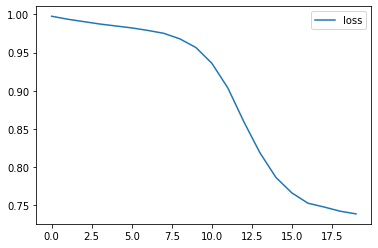

In [82]:
PQC_Readout.fit_summary()

In [83]:
PQC_Readout_res = PQC_Readout.predict(x_test)

In [84]:
performance_evaluation(y_test,PQC_Readout_res,'PQC_R_20epoch_enedis_15')

TP : 11	FP : 1
FN : 34	TN : 0

------------------

Precision RS : 0.9166666666666666
Recall : 0.9166666666666666
Precision RP : 0.0
Specificity : 0.0
Accuracy : 0.2391304347826087
Balanced Accuracy : 0.12222222222222222
F1 Score : 0.38596491228070173


PCA :

In [297]:
x_train_pca, x_test_pca = PCA(x_train, x_test,n_components=4)

In [298]:
n_layers = 5
epochs = 100
batch_size = 1

In [299]:
PQC_Readout = PQC_Readout_Classifier()
PQC_Readout.training(x_train_pca,y_train,n_layers,epochs,batch_size)

Data embedding
Creating circuit
Start of training
Epoch 1/100
103/103 [==============================] - 1s 6ms/step - loss: 0.8791 - custom_accuracy: 0.5860 

KeyboardInterrupt: 

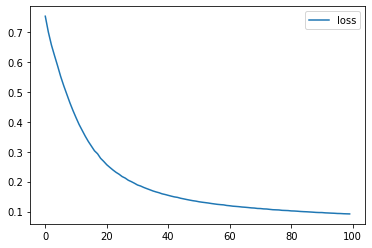

In [60]:
PQC_Readout.fit_summary()

In [61]:
PQC_Readout_res = PQC_Readout.predict(x_test_pca)

In [62]:
performance_evaluation(y_test,PQC_Readout_res,'PQC_R_50epoch_enedis_15_pca_4')

TP : 1	FP : 0
FN : 1	TN : 3

------------------

Precision RS : 1.0
Recall : 1.0
Precision RP : 0.75
Specificity : 1.0
Accuracy : 0.8
Balanced Accuracy : 0.75
F1 Score : 0.6666666666666666


## PQC QCNN

In [191]:
x_train, y_train, x_test, y_test = load_data_file(15,"o")

In [192]:
epochs = 50
batch_size = 1

In [193]:
PQC_QCNN = PQC_Convolutional_Classifier()
PQC_QCNN.training(x_train,y_train,epochs,batch_size)

Data embedding
Creating circuit
Start of training
Epoch 1/50
9/9 [==============================] - 4s 374ms/step - loss: 1.0064 - custom_accuracy: 0.5894
Epoch 2/50
9/9 [==============================] - 3s 370ms/step - lo

In [194]:
#PQC_Readout.more_epochs(20,batch_size)

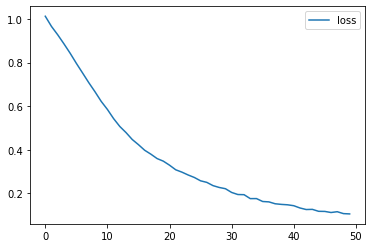

In [195]:
PQC_QCNN.fit_summary()

In [196]:
PQC_QCNN_res = PQC_QCNN.predict(x_test)

In [198]:
performance_evaluation(y_test,PQC_QCNN_res,"QCNN_50epochs_ENEDIS_15")

TP : 0	FP : 1
FN : 2	TN : 2

------------------

Precision RS : 0.0
Recall : 0.0
Precision RP : 0.5
Specificity : 0.6666666666666666
Accuracy : 0.4
Balanced Accuracy : 0.3333333333333333
F1 Score : 0.0


PCA :

In [92]:
x_train, y_train, x_test, y_test = load_data_file(1500,"o")

In [93]:
x_train_pca, x_test_pca = PCA(x_train, x_test,n_components=4)

In [94]:
epochs = 10
batch_size = 10

In [95]:
PQC_QCNN = PQC_Convolutional_Classifier()
PQC_QCNN.training(x_train_pca,y_train,epochs,batch_size)

Data embedding
Creating circuit
Start of training
Epoch 1/10
105/105 [==============================] - 5s 47ms/step - loss: 0.8128 - custom_accuracy: 0.7126

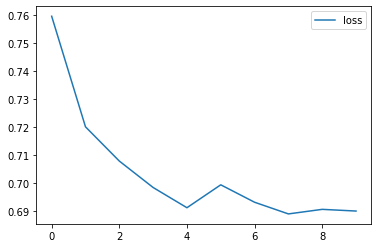

In [96]:
PQC_QCNN.fit_summary()

In [97]:
PQC_QCNN_res = PQC_QCNN.predict(x_test_pca)

In [98]:
performance_evaluation(y_test,PQC_QCNN_res,"PQC_QCNN_10epoch_enedis_1500_pca_4")

TP : 10	FP : 110
FN : 4	TN : 327

------------------

Precision RS : 0.08333333333333333
Recall : 0.08333333333333333
Precision RP : 0.9879154078549849
Specificity : 0.7482837528604119
Accuracy : 0.7472283813747228
Balanced Accuracy : 0.7312847335730631
F1 Score : 0.14925373134328357


## PQC Hybrid QCNN

In [17]:
x_train, y_train, x_test, y_test = load_data_file(150,50)

In [18]:
epochs = 50
batch_size = 10
n_layer = 2
n_dense = 15

In [19]:
PQC_H_QCNN = PQC_Convolutional_Hybrid_Classifier()
PQC_H_QCNN.training(x_train,y_train,n_layer,n_dense,epochs,batch_size)

Data embedding
Creating circuit
Start of training
Epoch 1/50
11/11 [==============================] - 35s 3s/step - loss: 1.0417 - custom_accuracy: 0.4791

In [20]:
#PQC_H_QCNN.more_epoch(20,batch_size)

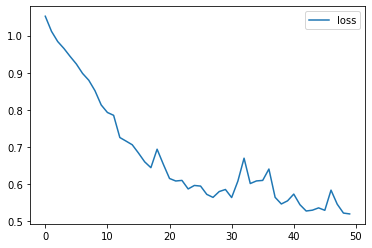

In [21]:
PQC_H_QCNN.fit_summary()

In [23]:
PQC_H_QCNN_res = PQC_H_QCNN.predict(x_test)

In [24]:
performance_evaluation(y_test,PQC_H_QCNN_res)

TP : 4	FP : 8
FN : 26	TN : 7

------------------

Precision RS : 0.3333333333333333
Recall : 0.3333333333333333
Precision RP : 0.21212121212121213
Specificity : 0.4666666666666667
Accuracy : 0.24444444444444444
Balanced Accuracy : 0.3
F1 Score : 0.19047619047619047


PCA :

In [121]:
x_train, y_train, x_test, y_test = load_data_file(1500,"o")

In [122]:
x_train_pca, x_test_pca = PCA(x_train, x_test,n_components=4)

In [128]:
epochs = 20
batch_size = 10
n_layer = 1
n_dense = 4

In [129]:
PQC_H_QCNN = PQC_Convolutional_Hybrid_Classifier()
PQC_H_QCNN.training(x_train_pca,y_train,n_layer,n_dense,epochs,batch_size)

Data embedding
Creating circuit
Start of training
Epoch 1/20
105/105 [==============================] - 3s 25ms/step - loss: 0.8356 - custom_accuracy: 0.7054

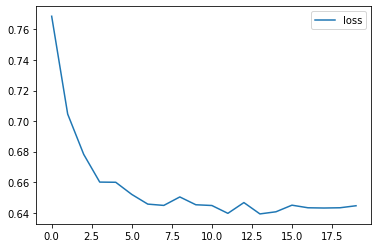

In [130]:
PQC_H_QCNN.fit_summary()

In [131]:
PQC_H_QCNN_res = PQC_H_QCNN.predict(x_test_pca)

In [132]:
performance_evaluation(y_test,PQC_H_QCNN_res,"PQC_QCNN_20epoch_enedis_1500_pca_4_dense4")

TP : 16	FP : 104
FN : 7	TN : 324

------------------

Precision RS : 0.13333333333333333
Recall : 0.13333333333333333
Precision RP : 0.9788519637462235
Specificity : 0.7570093457943925
Accuracy : 0.753880266075388
Balanced Accuracy : 0.726330759853718
F1 Score : 0.22377622377622378


# Hybrid SVM Classifier

In [136]:
#Import Hybrid SVM classifier
%run ./Classifiers/QC_SVM.ipynb

In [142]:
x_train, y_train, x_test, y_test = load_data_file(150,"o")

In [143]:
QC_SVM = QC_SVM_Classifier()
QC_SVM.training(x_train, y_train, C = 1, epsilon = 1e-8, entang_gate = "I1/2SWAP", repetitions = 10000)

Setting training Data and parameters
Computing matrix (increasing time for each iteration)


100%|██████████| 102/102 [05:48<00:00,  3.42s/it]


Training the SVM
Training completed


In [144]:
QC_SVM_res = QC_SVM.predict(x_test)

100%|██████████| 46/46 [03:04<00:00,  4.02s/it]


In [145]:
performance_evaluation(y_test,QC_SVM_res,"QC_SVM_enedis_150")

TP : 5	FP : 7
FN : 13	TN : 21

------------------

Precision RS : 0.4166666666666667
Recall : 0.4166666666666667
Precision RP : 0.6176470588235294
Specificity : 0.75
Accuracy : 0.5652173913043478
Balanced Accuracy : 0.5138888888888888
F1 Score : 0.3333333333333333


In [45]:
for C in [0.001,0.01,0.1,1,10] :
    print("C : ",C)
    QC_SVM.C = C
    QC_SVM.fit()
    QC_SVM_res = QC_SVM.predict(x_test)
    performance_evaluation(y_test,QC_SVM_res)
    print("--------------------")

C :  0.001


100%|██████████| 45/45 [04:58<00:00,  6.64s/it]


TP : 7	FP : 5
FN : 19	TN : 14

------------------

Precision RS : 0.5833333333333334
Recall : 0.5833333333333334
Precision RP : 0.42424242424242425
Specificity : 0.7368421052631579
Accuracy : 0.4666666666666667
Balanced Accuracy : 0.5030364372469636
F1 Score : 0.3684210526315789
--------------------
C :  0.01


100%|██████████| 45/45 [05:00<00:00,  6.67s/it]


TP : 7	FP : 5
FN : 19	TN : 14

------------------

Precision RS : 0.5833333333333334
Recall : 0.5833333333333334
Precision RP : 0.42424242424242425
Specificity : 0.7368421052631579
Accuracy : 0.4666666666666667
Balanced Accuracy : 0.5030364372469636
F1 Score : 0.3684210526315789
--------------------
C :  0.1


100%|██████████| 45/45 [05:03<00:00,  6.74s/it]


TP : 8	FP : 4
FN : 18	TN : 15

------------------

Precision RS : 0.6666666666666666
Recall : 0.6666666666666666
Precision RP : 0.45454545454545453
Specificity : 0.7894736842105263
Accuracy : 0.5111111111111111
Balanced Accuracy : 0.548582995951417
F1 Score : 0.42105263157894735
--------------------
C :  1


100%|██████████| 45/45 [04:30<00:00,  6.00s/it]


TP : 6	FP : 6
FN : 19	TN : 14

------------------

Precision RS : 0.5
Recall : 0.5
Precision RP : 0.42424242424242425
Specificity : 0.7
Accuracy : 0.4444444444444444
Balanced Accuracy : 0.47
F1 Score : 0.32432432432432434
--------------------
C :  10


100%|██████████| 45/45 [04:00<00:00,  5.35s/it]

TP : 5	FP : 7
FN : 17	TN : 16

------------------

Precision RS : 0.4166666666666667
Recall : 0.4166666666666667
Precision RP : 0.48484848484848486
Specificity : 0.6956521739130435
Accuracy : 0.4666666666666667
Balanced Accuracy : 0.4614624505928854
F1 Score : 0.29411764705882354
--------------------


##### Test on breast cancer cell dataset

In [33]:
x_breast_load = np.load("x_breast_cancer.npy")
label_breast = np.load("label_breast_cancer.npy")

x_breast = rescale(x_breast_load)
label_breast = label_breast*2. - 1.

In [34]:
keeped_ratio = 1.0
train_test_ratio = 0.7

keeped_indexes = np.random.choice(list(range(len(x_breast))),int(len(x_breast)*keeped_ratio))
cut_index = int(len(keeped_indexes)*train_test_ratio)

x_breast_train = np.array([x_breast[i] for i in keeped_indexes[:cut_index]])
label_train = np.array([label_breast[i] for i in keeped_indexes[:cut_index]])

x_breast_test = np.array([x_breast[i] for i in keeped_indexes[cut_index:]])
label_test = np.array([label_breast[i] for i in keeped_indexes[cut_index:]])

In [ ]:
QC_SVM = QC_SVM_Classifier()
QC_SVM.training(x_breast_train, label_train, C = 1, epsilon = 1e-8, entang_gate = "I1/2SWAP", repetitions = 10000)

  0%|          | 1/397 [00:00<00:53,  7.36it/s]

Setting training Data and parameters
Computing matrix (increasing time for each iteration)


 71%|███████▏  | 283/397 [1:22:26<1:02:23, 32.84s/it]

In [ ]:
QC_SVM_res_brest = QC_SVM.predict(x_breast_test)

 16%|█▋        | 28/171 [23:44<1:56:49, 49.02s/it]

In [ ]:
res = [int(y) for y in (label_test+1)/2]

In [ ]:
performance_evaluation(res,QC_SVM_res_brest)

# Quantum SVM Classifier

In [303]:
#Import Quantum SVM classifier
%run ./Classifiers/Q_SVM.ipynb

In [311]:
x_train, y_train, x_test, y_test = load_data_file(150,'o')

### Hadamar

In [305]:
Q_SVM_Hadamar = Q_SVM_Hadamar_Classifier()
Q_SVM_Hadamar_res = Q_SVM_Hadamar.predict(x_train, y_train,x_test, repetitions = 10000,norm_variable = False)

/dds/miniconda/envs/quantum2/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide


Simulation of 14 qubits


  0%|          | 0/46 [01:11<?, ?it/s]


KeyboardInterrupt: 

In [95]:
performance_evaluation(y_test,Q_SVM_Hadamar_res,"Hadam_15")

TP : 0	FP : 1
FN : 0	TN : 4

------------------

Precision RS : 0.0
Recall : 0.0
Precision RP : 1.0
Specificity : 0.8
Accuracy : 0.8
Balanced Accuracy : None
F1 Score : 0.0


PCA :

In [312]:
x_train_pca, x_test_pca = PCA(x_train, x_test,n_components=4)

In [307]:
Q_SVM_Hadamar = Q_SVM_Hadamar_Classifier()
Q_SVM_Hadamar_res = Q_SVM_Hadamar.predict(x_train_pca, y_train,x_test_pca, repetitions = 10000,norm_variable = False)

Simulation of 11 qubits


 13%|█▎        | 6/46 [01:29<09:59, 14.98s/it]


KeyboardInterrupt: 

In [152]:
performance_evaluation(y_test,Q_SVM_Hadamar_res,"Hadam_15_PCA_4")

TP : 1	FP : 0
FN : 1	TN : 3

------------------

Precision RS : 1.0
Recall : 1.0
Precision RP : 0.75
Specificity : 1.0
Accuracy : 0.8
Balanced Accuracy : 0.75
F1 Score : 0.6666666666666666


### SWAP

In [ ]:
Q_SVM_SWAP = Q_SVM_SWAP_Classifier()
Q_SVM_SWAP_res = Q_SVM_SWAP.predict(x_train, y_train,x_test,1, repetitions = 10000,norm_variable = False)

Preparing data circuit


/dds/miniconda/envs/quantum2/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


In [133]:
performance_evaluation(y_test,Q_SVM_SWAP_res,"swap_15_dense")

TP : 0	FP : 1
FN : 0	TN : 4

------------------

Precision RS : 0.0
Recall : 0.0
Precision RP : 1.0
Specificity : 0.8
Accuracy : 0.8
Balanced Accuracy : None
F1 Score : 0.0


PCA :

In [197]:
x_train_pca, x_test_pca = PCA(x_train, x_test,n_components=8)

In [182]:
Q_SVM_SWAP = Q_SVM_SWAP_Classifier()
Q_SVM_SWAP_res = Q_SVM_SWAP.predict(x_train_pca, y_train,x_test_pca,1, repetitions = 10000,norm_variable = False)

Preparing data circuit
Simulation of 10 qubits
Classifying


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


In [183]:
performance_evaluation(y_test,Q_SVM_SWAP_res,"swap_15_PCA_4")

TP : 0	FP : 1
FN : 0	TN : 4

------------------

Precision RS : 0.0
Recall : 0.0
Precision RP : 1.0
Specificity : 0.8
Accuracy : 0.8
Balanced Accuracy : None
F1 Score : 0.0


Dense encoding :

In [190]:
def dense_encod (x_train,x_test):
    n_feats = math.ceil(len(x_train[0])/2)
    res_x_train = []
    for i in range(len(x_train)):
        point = []
        for j in range(n_feats) :
            try :
                point.append(x_train[i][2*j] + 1j*x_train[i][2*j+1])
            except :
                point.append(x_train[i][2*j])
        res_x_train.append(point)
    res_x_test = []
    for i in range(len(x_test)):
        point = []
        for j in range(n_feats) :
            try :
                point.append(x_test[i][2*j] + 1j*x_test[i][2*j+1])
            except :
                point.append(x_test[i][2*j])
        res_x_test.append(point)
    return np.array(res_x_train),np.array(res_x_test)

In [198]:
x_train_pca_dense,x_test_pca_dense = dense_encod(x_train_pca,x_test_pca)

In [201]:
Q_SVM_SWAP = Q_SVM_SWAP_Classifier()
Q_SVM_SWAP_res = Q_SVM_SWAP.predict(x_train_pca_dense, y_train,x_test_pca_dense,1, repetitions = 10000,norm_variable = False)

Preparing data circuit
Simulation of 13 qubits
Classifying


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]


In [202]:
performance_evaluation(y_test,Q_SVM_SWAP_res,"swap_150_PCA_8_dense")

TP : 12	FP : 0
FN : 32	TN : 2

------------------

Precision RS : 1.0
Recall : 1.0
Precision RP : 0.058823529411764705
Specificity : 1.0
Accuracy : 0.30434782608695654
Balanced Accuracy : 0.6363636363636364
F1 Score : 0.42857142857142855
